# Load data

In [1]:
import pandas as pd

from base64 import b64decode
def decode_program(code):
    return b64decode(code).decode("utf-8")

In [2]:
exercise_df = pd.read_csv("exercise.csv")
ipython = exercise_df[exercise_df["name"] == "IPython"]

log_df = pd.read_csv('data/umimeprogramovatcz-ipython_log.csv', sep=';')
questions_df = pd.read_csv('data/umimeprogramovatcz-ipython_item.csv', sep=';')
log_df.drop(list(range(424)), inplace=True)
log_df.reset_index(inplace=True, drop=True)

## Exercise dataframe

In [3]:
exercise_df

,id,name,short,type,questions,log,column,dropMode,hasRT,sumTime,globalMaxTime,doBoxplot,sortCriterium,fromTime
0,1,Doplňovačka stará,xxx,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0,0,NaN
1,2,Otázky staré,yyy,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0,0,NaN
2,3,Diktáty,diktaty,medal,dictate.csv,dictate_session_log.csv,dictate,NaN,0.0,0.0,0.0,0,0,NaN
3,4,Čárky,carky,medal,carky_sentence.csv,carky_sentence_log.csv,sentence,NaN,0.0,0.0,0.0,0,0,NaN
4,5,Rozbory,rozbory,medal,vetne_cleny_sentence.csv,vetne_cleny_log.csv,sentence,NaN,1.0,0.0,0.0,0,0,2018-01-01
5,6,Vtipy,vtipy,item,vtipy_joke.csv,vtipy_log.csv,item,NaN,1.0,1.0,0.0,0,0,NaN
6,7,Roboti,roboti,level,NaN,roboti_session_log.csv,NaN,NaN,1.0,0.0,0.0,0,0,NaN
7,8,Střílečka,stril,level,NaN,shooter_session_log.csv,NaN,NaN,1.0,0.0,0.0,0,0,NaN
8,9,Tetris,tetris,level,NaN,tetris_session_log.csv,NaN,NaN,1.0,0.0,0.0,0,0,NaN
9,10,Závody,zavody,multi,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0,0,NaN


## IPython record (from exercise_df)

In [4]:
ipython

,id,name,short,type,questions,log,column,dropMode,hasRT,sumTime,globalMaxTime,doBoxplot,sortCriterium,fromTime
33,35,IPython,ipython,item,ipython_item.csv,ipython_log.csv,item,keep_only_last,1.0,0.0,1.0,1,ordering,2018-02-21


## Log dataframe

In [5]:
log_df.head(10)

,id,user,item,answer,correct,moves,responseTime,time
0,1966,1625382,13,ZGVmIHN0cmluZ19pbnRlcnNlY3Rpb24obGVmdCwgcmlnaH...,1,-1,423250,2017-12-06 15:12:17
1,1967,1625382,14,ZGVmIHBhbGluZHJvbSh0ZXh0KTpicmVhayAgICBpZiBsZW...,1,-1,730000,2017-12-06 16:10:43
2,1976,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,28350,2017-12-06 17:44:30
3,1977,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,55100,2017-12-06 17:44:57
4,1979,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,151500,2017-12-06 17:46:33
5,1980,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,193900,2017-12-06 17:48:45
6,1981,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,194850,2017-12-06 17:48:46
7,1982,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,195700,2017-12-06 17:48:47
8,1983,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,196300,2017-12-06 17:48:47
9,1984,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,196650,2017-12-06 17:48:48


## Questions dataframe

In [6]:
questions_df

,id,name,instructions,democode,testcode,solution,tests,medianTime,ordering,visible,created
0,1,Výpis čísel,"[[""html"",""Napište funkci <b>numbers(n)</b>, kt...","[[""python64"",""ZGVmIG51bWJlcnMobik6CiAgICBwcmlu...","[[""python64"",""bnVtYmVycygxMCkK""]]","[[""python64"",""ZGVmIG51bWJlcnMobik6CiAgICBmb3Ig...","[[""python64"",""bnVtYmVycygzKQo=""],[""python64"",""...",136380,1,1,2017-11-21 18:17:19
1,2,Fibonacciho posloupnost,"[[""html"",""Napište funkci <b>fibonacci(n)</b>, ...","[[""python64"",""ZGVmIGZpYm9uYWNjaShuKToKICAgIGZv...","[[""python64"",""Zmlib25hY2NpKDEwKQo=""]]","[[""python64"",""ZGVmIGZpYm9uYWNjaShuKToKICAgIGN1...","[[""python64"",""Zmlib25hY2NpKDUpCg==""],[""python6...",136380,7,1,2017-11-21 18:17:19
2,3,Faktoriál,"[[""html"",""Napište funkci <b>factorial(n)</b> v...","[[""python64"",""ZGVmIGZhY3RvcmlhbChuKToKICAgIHJl...","[[""python64"",""cHJpbnQoZmFjdG9yaWFsKDUpKQo=""]]","[[""python64"",""ZGVmIGZhY3RvcmlhbChuKToKICAgIHZh...","[[""python64"",""cHJpbnQoZmFjdG9yaWFsKDYpKQo=""],[...",136380,7,1,2017-11-21 18:17:19
3,4,Abeceda,"[[""html"",""Napište funkci <b>alphabet(n)</b>, k...","[[""python64"",""ZGVmIGFscGhhYmV0KG4pOgogICAgZm9y...","[[""python64"",""YWxwaGFiZXQoMzApCg==""]]","[[""python64"",""ZGVmIGFscGhhYmV0KG4pOgogICAgZm9y...","[[""python64"",""YWxwaGFiZXQoMTApCg==""],[""python6...",136380,10,1,2017-11-21 18:17:19
4,5,Zdvojení znaků,"[[""html"",""Napište funkci <b>duplication(text)<...","[[""python64"",""ZGVmIGR1cGxpY2F0aW9uKHRleHQpOgog...","[[""python64"",""cHJpbnQoZHVwbGljYXRpb24oIlBZVEhP...","[[""python64"",""ZGVmIGR1cGxpY2F0aW9uKHRleHQpOgog...","[[""python64"",""cHJpbnQoZHVwbGljYXRpb24oIkFBIikp...",193233,3,1,2017-11-21 18:17:19
5,6,Součin nenulových,"[[""html"",""Napište funkci <b>nonzero_product(nu...","[[""python64"",""ZGVmIG5vbnplcm9fcHJvZHVjdChudW1i...","[[""python64"",""cHJpbnQobm9uemVyb19wcm9kdWN0KFs0...","[[""python64"",""ZGVmIG5vbnplcm9fcHJvZHVjdChudW1i...","[[""python64"",""cHJpbnQobm9uemVyb19wcm9kdWN0KFsw...",149201,2,1,2017-11-21 18:17:19
6,7,Dělitelé,"[[""html"",""Napište funkci <b>divisors(n)</b>, k...","[[""python64"",""ZGVmIGRpdmlzb3JzKG4pOgogICAgcHJp...","[[""python64"",""ZGl2aXNvcnMoMjQpCg==""]]","[[""python64"",""ZGVmIGRpdmlzb3JzKG4pOgogICAgZm9y...","[[""python64"",""ZGl2aXNvcnMoNSkK""],[""python64"",""...",193233,1,1,2017-11-21 18:17:19
7,8,Čtverec,"[[""html"",""Napište funkci <b>square(n)</b>, kte...","[[""python64"",""ZGVmIHNxdWFyZShuKToKICAgIGZvciBp...","[[""python64"",""c3F1YXJlKDUpCg==""]]","[[""python64"",""ZGVmIHNxdWFyZShuKToKICAgIGZvciBp...","[[""python64"",""c3F1YXJlKDMpCg==""],[""python64"",""...",193233,1,1,2017-11-21 18:17:19
8,9,Prázdný čtverec,"[[""html"","" Napište funkci <b>empty_square(n)</...","[[""python64"",""ZGVmIGVtcHR5X3NxdWFyZShuKToKICAg...","[[""python64"",""ZW1wdHlfc3F1YXJlKDUpCg==""]]","[[""python64"",""ZGVmIGVtcHR5X3NxdWFyZShuKToKICAg...","[[""python64"",""ZW1wdHlfc3F1YXJlKDYpCg==""],[""pyt...",193233,2,1,2017-11-21 18:17:19
9,10,Pyramida,"[[""html"",""Napište funkci <b>pyramid(n)</b>, kt...","[[""python64"",""ZGVmIHB5cmFtaWQobik6CiAgICBmb3Ig...","[[""python64"",""cHlyYW1pZCg1KQo=""]]","[[""python64"",""ZGVmIHB5cmFtaWQobik6CiAgICBmb3Ig...","[[""python64"",""cHlyYW1pZCg2KQo=""],[""python64"",""...",193233,4,1,2017-11-21 18:17:19


# Filter only decodable answers

In [7]:
valid = ['True' for _ in range(log_df.shape[0])]
log_df['valid'] = valid

for index, answer in log_df['answer'].items():
    try:
        #print(index, answer)
        #padding = (4 - len(answer) % 4) * "="
        decode_program(answer)
    except:
        log_df.at[index, 'valid'] = 'False'

In [8]:
log_df = log_df[log_df['valid'] == 'True']

## Filtered log dataframe
Also drop 'valid' column and add 'codeLength' column.

In [9]:
log_df.drop('valid', axis=1, inplace=True)

In [10]:
def get_code_length(row):
    code = decode_program(row['answer'])
    length = code.count("break") + code.count("\n")
    if code.count("\n") > 0:
        length += 1
    return length

log_df['codeLength'] = log_df.apply(get_code_length, axis=1)

In [11]:
log_df.reset_index(inplace=True, drop=True)
log_df.head(10)

,id,user,item,answer,correct,moves,responseTime,time,codeLength
0,1976,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,28350,2017-12-06 17:44:30,2
1,1977,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,55100,2017-12-06 17:44:57,2
2,1979,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,151500,2017-12-06 17:46:33,1
3,1980,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,193900,2017-12-06 17:48:45,1
4,1981,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,194850,2017-12-06 17:48:46,1
5,1982,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,195700,2017-12-06 17:48:47,1
6,1983,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,196300,2017-12-06 17:48:47,1
7,1984,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,196650,2017-12-06 17:48:48,1
8,1985,1518209,31,YnJlYWs=,0,-1,264550,2017-12-06 17:49:56,1
9,1986,1518209,31,YnJlYWs=,0,-1,272200,2017-12-06 17:50:03,1


# Statistics


In [12]:
g_min = log_df.groupby("item").min().add_suffix('Min')
g_mean = log_df.groupby("item").mean().add_suffix('Mean')
g_max = log_df.groupby("item").max().add_suffix('Max')

In [13]:
stats_df = pd.concat([g_min, g_mean, g_max], axis=1, sort=False)
stats_df = stats_df[['correctMean', 'responseTimeMin', 'responseTimeMean', 'responseTimeMax',
                    'codeLengthMin', 'codeLengthMean', 'codeLengthMax']]
stats_df['numAnswers'] = log_df.groupby("item").count()["id"]
stats_df.reset_index(inplace=True)
stats_df.responseTimeMean = stats_df.responseTimeMean.round().astype(int)
stats_df.codeLengthMean = stats_df.codeLengthMean.round().astype(int)

In [14]:
stats_df

,item,correctMean,responseTimeMin,responseTimeMean,responseTimeMax,codeLengthMin,codeLengthMean,codeLengthMax,numAnswers
0,1,0.518519,1000,151758,2139850,1,4,14,702
1,2,0.500000,1600,696108,10675550,4,9,31,180
2,3,0.524590,5400,385068,5458200,1,6,82,427
3,4,0.242958,900,682957,11681250,0,7,36,284
4,5,0.630662,4400,374794,13754050,2,6,11,287
5,6,0.698885,1500,314027,9471050,3,7,14,269
6,7,0.501370,4500,192110,3402600,2,5,13,365
7,8,0.460342,1400,307398,5935450,2,7,29,643
8,9,0.417178,5500,698860,7667200,4,10,23,489
9,10,0.512195,950,784751,18703300,0,7,17,246


# Plots
Following graphs (statistics) are computed from every solution attempt, not only final solutions.

In [15]:
import matplotlib.pyplot as plt

### Success rate

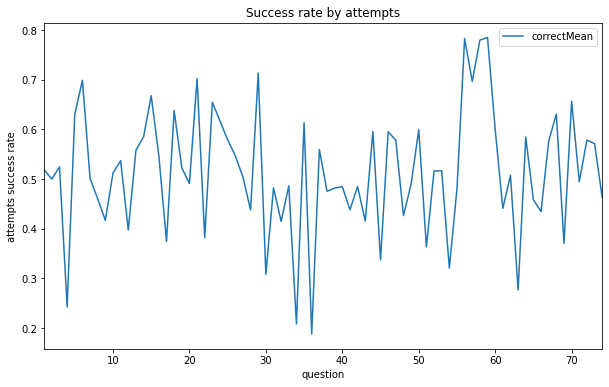

In [16]:
ax = plt.gca()

stats_df.plot(kind='line', x='item', y='correctMean', title='Success rate by attempts', figsize=(10, 6), ax=ax)

ax.set_ylabel('attempts success rate')
ax.set_xlabel('question')
plt.show()

### Response time
Minimum, average and maximum response time for each question.

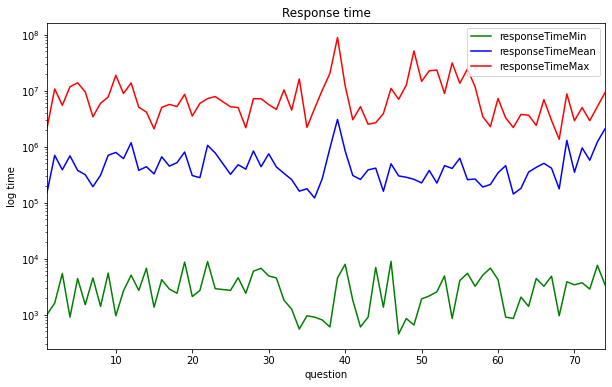

In [17]:
ax = plt.gca()

stats_df.plot(kind='line', x='item', y='responseTimeMin', color='green', logy=True, figsize=(10, 6),
              title="Response time", ax=ax) 
stats_df.plot(kind='line', x='item', y='responseTimeMean', color='blue', logy=True, ax=ax)
stats_df.plot(kind='line', x='item', y='responseTimeMax', color='red', logy=True, ax=ax)

ax.set_ylabel('log time')
ax.set_xlabel('question')
plt.show()

### Code length in lines
Lowest, average and highest number of lines for each question.

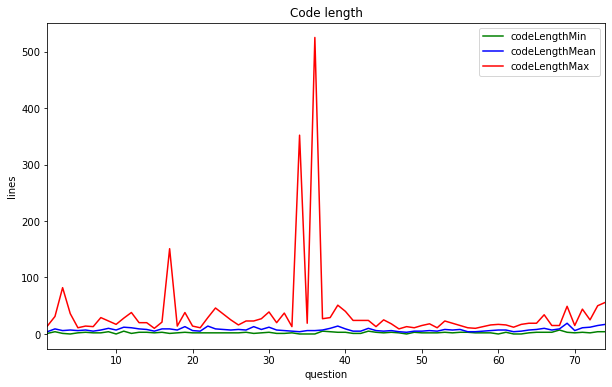

In [18]:
ax = plt.gca()

stats_df.plot(kind='line', x='item', y='codeLengthMin', color='green', figsize=(10, 6), title="Code length", ax=ax) 
stats_df.plot(kind='line', x='item', y='codeLengthMean', color='blue', ax=ax)
stats_df.plot(kind='line', x='item', y='codeLengthMax', color='red', ax=ax)

ax.set_ylabel('lines')
ax.set_xlabel('question')
plt.show()